In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

p = print

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

dollar = pd.read_csv('./Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

In [2]:
from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling

from mlfinlab.util import multiprocess
from mlfinlab.util import volatility



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

In [3]:
vol = volatility.get_daily_vol(close=dollar['close'], lookback=50)
cusum_events = filters.cusum_filter(dollar['close'], threshold=vol.mean())
vertical_barriers = labeling.add_vertical_barrier(cusum_events, dollar['close'], num_days=1)
triple_barrier_events = labeling.get_events(close=dollar['close'],
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               min_ret=0.01,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

In [4]:
num_threads = 2
num_conc_events = multiprocess.mp_pandas_obj(concurrent.num_concurrent_events, 
                                             ('molecule', triple_barrier_events.index), 
                                             num_threads, 
                                             close_series_index=dollar['close'].index, 
                                             label_endtime=triple_barrier_events['t1'])

2020-05-07 16:29:08.360348 100.0% num_concurrent_events done after 0.08 minutes. Remaining 0.0 minutes.


In [5]:
num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep='last')]
num_conc_events = num_conc_events.reindex(dollar['close'].index).fillna(0)

In [6]:
av_unique = concurrent.get_av_uniqueness_from_triple_barrier(triple_barrier_events, 
                                                  close_series = dollar['close'], 
                                                  num_threads = num_threads)

2020-05-07 16:29:13.264448 100.0% num_concurrent_events done after 0.07 minutes. Remaining 0.0 minutes.
2020-05-07 16:29:18.089328 100.0% _get_average_uniqueness done after 0.07 minutes. Remaining 0.0 minutes.


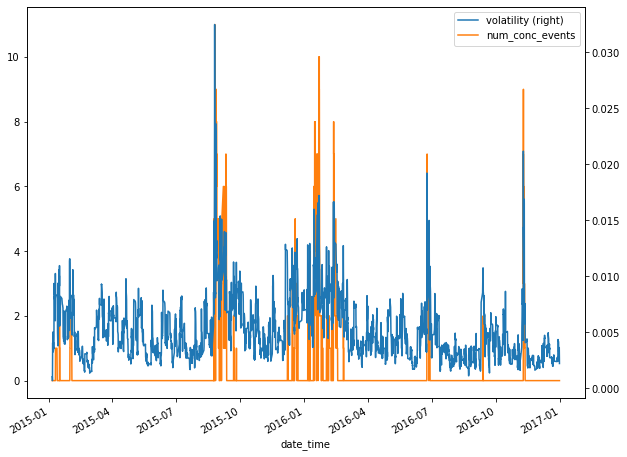

In [7]:
#num_conc_events.value_counts()

df0 = pd.DataFrame(index = num_conc_events.index).assign(volatility = vol, num_conc_events = num_conc_events)
df0 = df0.drop_duplicates().dropna()
df0[['volatility', 'num_conc_events']].plot(secondary_y='volatility', figsize=(10,8))
plt.show()

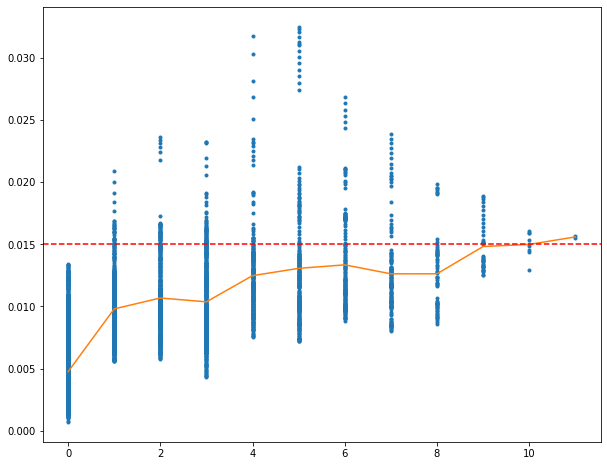

In [8]:
fig = plt.figure(figsize=(10,8))
df1 = df0.groupby(num_conc_events, axis = 0).mean() # Try piecewise estimate
plt.plot(df0['num_conc_events'], df0['volatility'], '.', df1['num_conc_events'], df1['volatility'], '-')
plt.axhline(y = 0.015, c='r', ls='--')
plt.show()

**Lagrange Multiplier tests for autocorrelation**

H0: the sequence was produced in a random manner.
    
H1: the sequence was not produced in a random manner.

If pval < 0.05 (Random: Accept H0)

In [9]:
from statsmodels.sandbox.stats import diagnostic

pval = diagnostic.acorr_lm(av_unique.squeeze(), maxlag = 1, autolag = 'AIC')[1]
p("pvalue for LM test: {0}".format(pval))

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


pvalue for LM test: 6.607158819770527e-23


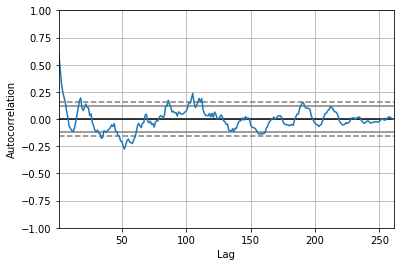

In [10]:
#Based on the below ACF, autocorr is considered significant (No sharp drop, nlag may go up to 100)

pd.plotting.autocorrelation_plot(av_unique.squeeze())

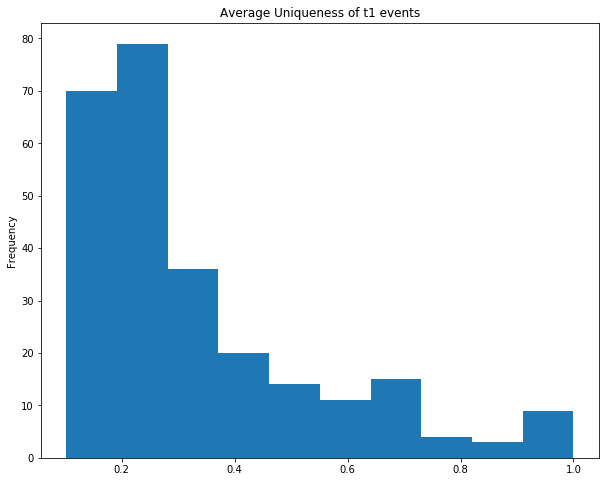

In [11]:
av_unique['tW'].plot(kind = 'hist', figsize=(10,8), title = 'Average Uniqueness of t1 events')
plt.show()

**Based on scatter graph**

Using mean as an estimate to plot a piecewise function graph, volatility and concurrency has a weak positive relationship.

Most mean estimate value per concurrenct event has never crossed medium frequency.

A spike in volatility will produce concurrent events however concurrent events may not cause as much volatility. 

Hence causality relationship.

**Based on LM autocorr test and ACF plot**

Average uniqueness of data set is statistically significant at autocorr 1.

Since data sample's average uniqueness is a derivation of weight distribution from concurrent event (With causality relationship with volatility).

More volatility => More concurrent event => Reduced average uniqueness (More imbalance) => Increased autocorrelation => More residual noise

The key implication where time-series is concerned, stationarity may be affected.

In [12]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [13]:
window = 50

def bband(data: pd.Series, span0: int = 50, width: int = 1):
    '''
    Basic bollinger band
    
    params: DataFrame => entire dataframe which close price resides
    params: int => span0 is how many to roll
    params: int => width to set 
    '''
    
    ma = data.ewm(span = span0).mean()
    std = data.ewm(span = span0).std()
    
    upper = ma + (std * width)
    lower = ma + (std * width)
    
    return ma, upper, lower

In [14]:
dollar['ma'], dollar['upper'], dollar['lower'] = bband(dollar['close'], span0 = window, width = 2)
dollar.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,ma,upper,lower
date_time,,,,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478,2056.750000,NaN,NaN
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,2060.447500,2070.700548,2070.700548
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152,2060.465705,2067.643100,2067.643100
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502,2060.607398,2066.433963,2066.433963
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,2061.287184,2067.059828,2067.059828


In [15]:
data = dollar
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

 1.0    23934
-1.0      144
Name: side, dtype: int64


In [16]:
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
print(data.side.value_counts())

 1.0    23934
-1.0      144
Name: side, dtype: int64


In [17]:
# Compute daily volatility
daily_vol = volatility.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [18]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            min_ret=min_ret,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side'])

2020-05-07 16:29:44.272231 100.0% apply_pt_sl_on_t1 done after 0.4 minutes. Remaining 0.0 minutes.


In [19]:
# Averge uniqueness
avg_uniqueness = concurrent.get_av_uniqueness_from_triple_barrier(triple_barrier_events, data['close'], num_threads=1)
p(avg_uniqueness.mean())

tW    0.039852
dtype: float64


In [20]:
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    15252
-1.0      125
Name: side, dtype: int64

In [21]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [22]:
# get autocorrelation residual
from statsmodels.tsa.arima_model import ARMA
def ar_model_resid(data: pd.DataFrame, nlags: int = 3):
    for i in np.arange(nlags):
        ar_model = ARMA(data['close'], order=(i,0)).fit().resid
        data['ar_resid'+ str(i)] = ar_model
    return data

raw_data = ar_model_resid(raw_data, nlags = 5)

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

In [35]:
X = raw_data.reindex(labels.index).dropna()
y = labels['bin'].iloc[6:]

# Remove only those I did not used
X.drop(['open', 'high', 'low', 'cum_vol', 'cum_dollar', 'cum_ticks'], axis=1, inplace=True)

In [36]:
# Split data into training, validation and test sets
X_training_test = X
y_training_test = y
X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)

In [37]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    6328
0    5968
Name: bin, dtype: int64

In [38]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [39]:
# extract parameters, due to the number of features it can take up to 5 mins

parameters = {'max_depth':[3, 4, 5, 7, 8, 9], #need to skip 6 if not ROC v weird recommend to start with 3
              'n_estimators':[25, 50, 100, 150, 250, 500], # if you want to have high OOB increase your estimators
              'random_state':[42]} # if you want to perform grid search random state has to be fixed

def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

# best parameter to be used

n_estimators, max_depth = perform_grid_search(X_train, y_train)
c_random_state = 42

[0.52970118 0.52805057 0.53479265 0.53591187 0.53506671 0.53300414
 0.5378547  0.5406553  0.54053975 0.54040131 0.54058603 0.54190125
 0.53835633 0.53407591 0.53875865 0.53627702 0.53809371 0.53804927
 0.53052076 0.53172467 0.53275349 0.53246497 0.53377124 0.53495253
 0.52397542 0.52908596 0.53103536 0.52999648 0.52903189 0.52968624]


In [40]:
print(n_estimators, max_depth, c_random_state)

500 3 42


#### Random Forest Classifer: OOB Score

Based on "Best" parameters from grid search CV.

In [41]:
# Random Forest Model
rf = RandomForestClassifier(max_depth = max_depth, 
                            n_estimators = n_estimators, 
                            oob_score = True, #set to True
                            criterion = 'entropy', 
                            random_state = c_random_state)

rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

Out-of-bag Accuracy (OOB Score): 0.582547


#### KFolds Split: KFolds Accuracy

Cross-Validation KFolds to compare, without shuffling.

In [42]:
# k-fold
no_of_folds = 5
kfold = KFold(shuffle=False, random_state=1, n_splits=no_of_folds)

accuracy_array = np.zeros(no_of_folds)
i = 0
for train_index, test_index in kfold.split(X_training_test):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train.values.ravel())

    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    accuracy_array[i] = accuracy_score(y_test, y_pred)
    i += 1
    
print("Mean KFold accuracy: {:.6f}".format(np.mean(accuracy_array)))

KFold(n_splits=5, random_state=1, shuffle=False)


**OOB Score vs Mean KFold Accuracy**

Mean KFold accuracy: 0.514474
Out-of-bag Accuracy (OOB Score): 0.582547
    
OOB score is about 7% higher compared to Mean KFold Accuracy score, this is quite significant.

Quoted in section 4.5 of AFML, page 62 states, "incorrect assuming IID draws leads to oversampling, when sample with replacement (bootstrap default = True)".

Quoted in section 4.5 of AFML, page 63 states, "random sampling will make out-of-bag examples very similar to in-the-bag ones, the OOB accuracy would be grossly inflated".

In [60]:
def get_time_decay(tw, clf_last_w=1.):
    # apply piecewise-linear decay to observed uniqueness (tw)
    # newest observation gets weight=1, oldest observation gets weight=clf_last_w
    clf_w = tw.sort_index().cumsum()
    if clf_last_w >= 0:
        slope = (1. - clf_last_w) / clf_w.iloc[-1]
    else:
        slope = 1. /((clf_last_w + 1) * clf_w.iloc[-1])
    
    const = 1. - slope * clf_w.iloc[-1]
    clf_w = const + slope * clf_w
    clf_w[clf_w < 0] = 0
    #print("Constant\n{0}\nSlope\n{1}\n".format(const, slope))
    return clf_w

In [74]:
w0 = get_time_decay(av_unique, 1.0)
w1 = get_time_decay(av_unique, 0.75)
w2 = get_time_decay(av_unique, 0.5)
w3 = get_time_decay(av_unique, -0.25)
w4 = get_time_decay(av_unique, -0.5)

In [75]:
decay_df = pd.DataFrame(index=av_unique.index).assign(
                              decay_1=w0,
                              decay_2=w1,
                              decay_3=w2,
                              decay_4=w3,
                              decay_5=w4)

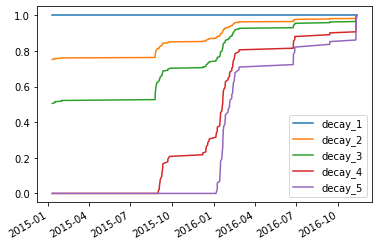

In [76]:
decay_df[['decay_1', 'decay_2', 'decay_3', 'decay_4', 'decay_5']].plot()

# Weirdest piecewise linear i ever seen

In [86]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, oob_score=True,
                            criterion='entropy', random_state=c_random_state)
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']
rf.fit(X_train, y_train.values.ravel())

print(rf)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
Out-of-bag Accuracy (OOB Score): 0.582547
              precision    recall  f1-score   support

           0       0.67      0.30      0.41      5968
           1       0.56      0.86      0.68      6328

    accuracy                           0.59     12296
   macro avg       0.62      0.58      0.55     12296
weighted avg       0.62      0.59      0.55     12296

Confusion Matrix
[[1770 4198]
 [ 876 5452]]

Accuracy
0.5873454782042941


In [87]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.22      0.29      1525
           1       0.48      0.72      0.58      1549

    accuracy                           0.47      3074
   macro avg       0.46      0.47      0.43      3074
weighted avg       0.46      0.47      0.44      3074

Confusion Matrix
[[ 333 1192]
 [ 432 1117]]

Accuracy
0.4716981132075472


In [88]:
rf = RandomForestClassifier(max_depth=max_depth, 
                            n_estimators=n_estimators, 
                            oob_score=True,
                            class_weight='balanced', #just include class_weight = 'balance_subsample'
                            criterion='entropy', 
                            random_state=c_random_state)
print(rf)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_)) #OOB score increase signifcantly 

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)
Out-of-bag Accuracy (OOB Score): 0.607515


In [89]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.47      0.55      5968
           1       0.60      0.76      0.68      6328

    accuracy                           0.62     12296
   macro avg       0.63      0.62      0.61     12296
weighted avg       0.63      0.62      0.61     12296

Confusion Matrix
[[2802 3166]
 [1489 4839]]

Accuracy
0.6214216005204944


In [90]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.41      0.44      1525
           1       0.49      0.57      0.53      1549

    accuracy                           0.49      3074
   macro avg       0.49      0.49      0.49      3074
weighted avg       0.49      0.49      0.49      3074

Confusion Matrix
[[621 904]
 [664 885]]

Accuracy
0.48991541964866625
